# In this notebook we present data preprocessing for training ViT models.

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix
from pneumonia_utils import load_pneumonia, visualize_data, image_wrangling, image_normalize, extract_by_label
from pneumonia_models import Patches, PatchEncoder, vision_transformer
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, models, activations, metrics

sns.set_theme()
tf.test.is_built_with_cuda()

True

## Data wrangling and exploration

In [2]:
# Load data
data = load_pneumonia(".//data//chest_xray//chest_xray")
train_data = data["train"]
val_data = data["val"]
test_data = data["test"]

# Turn into Pandas DataFrames
train_df = pd.DataFrame(train_data, columns=["image", "label"])
val_df = pd.DataFrame(val_data, columns=["image", "label"])
test_df = pd.DataFrame(test_data, columns=["image", "label"])

In [3]:
# Count samples
print(f"Number of samples in train dataset: {len(train_data)}")
train_counts = train_df["label"].value_counts()
print(f"Pneumonia cases: {train_counts[1]} and Normal cases: {train_counts[0]}\n")

print(f"Number of samples in validation dataset: {len(val_data)}")
val_counts = val_df["label"].value_counts()
print(f"Pneumonia cases: {val_counts[1]} and Normal cases: {val_counts[0]}\n")

print(f"Number of samples in test dataset: {len(test_data)}")
test_counts = test_df["label"].value_counts()
print(f"Pneumonia cases: {test_counts[1]} and Normal cases: {test_counts[0]}")

Number of samples in train dataset: 5216
Pneumonia cases: 3875 and Normal cases: 1341

Number of samples in validation dataset: 16
Pneumonia cases: 8 and Normal cases: 8

Number of samples in test dataset: 624
Pneumonia cases: 390 and Normal cases: 234


TRAIN DATASET


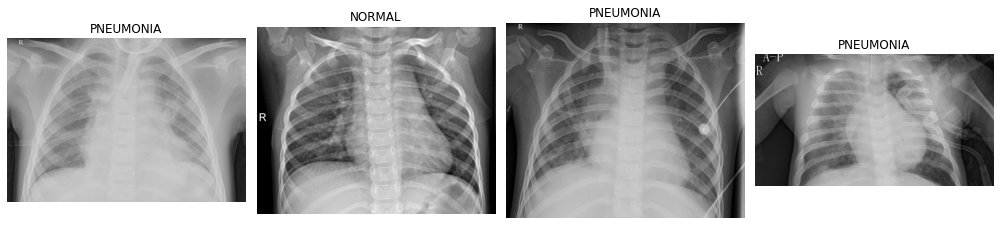

VALIDATION DATASET


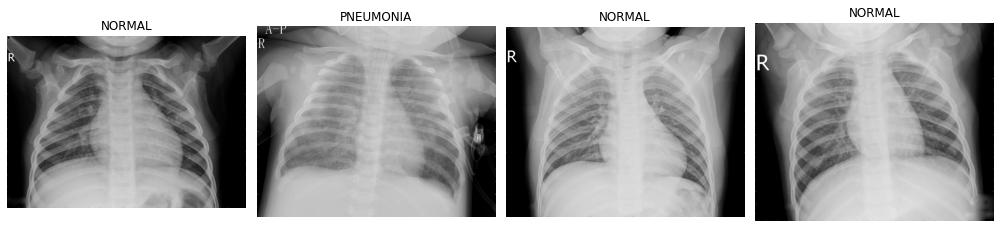

TEST DATASET


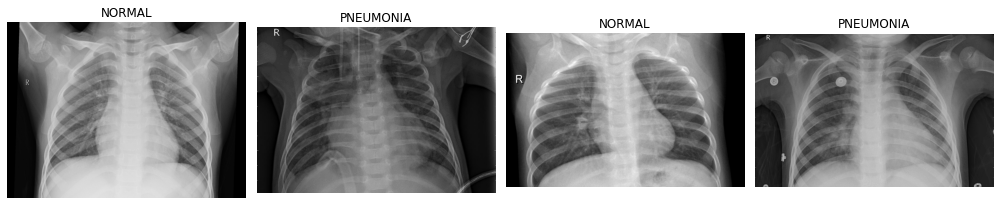

In [4]:
# Visualize some samples from each dataset
print("TRAIN DATASET")
visualize_data(train_data)
print("VALIDATION DATASET")
visualize_data(val_data)
print("TEST DATASET")
visualize_data(test_data)

In [5]:
# Following the data description and other works -> some images are in grayscale and some are are RGB
train_shapes = []
val_shapes = []
test_shapes = []
# (height, width, num channels [optional])
for i in range(len(train_data)):
    train_shapes.append(len(train_data[i][0].shape))

for i in range(len(val_data)):
    val_shapes.append(len(val_data[i][0].shape))

for i in range(len(test_data)):
    test_shapes.append(len(test_data[i][0].shape))

print(f"Shapes in train dataset: {np.unique(train_shapes, return_counts=True)}")
print(f"Shapes in validation dataset: {np.unique(val_shapes, return_counts=True)}")
print(f"Shapes in test dataset: {np.unique(test_shapes, return_counts=True)}")

# 3-channel images exist only in training dataset (should be handled properly)

Shapes in train dataset: (array([2, 3]), array([4933,  283], dtype=int64))
Shapes in validation dataset: (array([2]), array([16], dtype=int64))
Shapes in test dataset: (array([2]), array([624], dtype=int64))


In [6]:
# Turning RGB images to grayscale
for i in range(len(train_data)):
    # As data samples are tuples (we are unable to perform inside assignments) we turn them into lists and then back into tuples
    as_list = list(train_data[i])
    if len(as_list[0].shape) == 3:
        temp_img = cv2.cvtColor(as_list[0], cv2.COLOR_RGB2GRAY)
        as_list[0] = temp_img
    as_tuple = tuple(as_list)
    train_data[i] = as_tuple

train_shapes_new = []
for i in range(len(train_data)):
    train_shapes_new.append(len(train_data[i][0].shape))

print(f"New shapes in train dataset: {np.unique(train_shapes_new, return_counts=True)}")

New shapes in train dataset: (array([2]), array([5216], dtype=int64))


In [7]:
# Images preparation -> reshaping them to the same shape and expanding into 3 channels
print(f"Shapes of some random images in training dataset: {train_data[3000][0].shape}, {train_data[1000][0].shape}")
train_data = image_wrangling(data=train_data, output_shape=(224,224))
val_data = image_wrangling(data=val_data, output_shape=(224,224))
test_data = image_wrangling(data=test_data, output_shape=(224,224))
print(f"Shapes of some random images in training dataset: {train_data[3000][0].shape}, {train_data[1000][0].shape}")

Shapes of some random images in training dataset: (640, 1008), (1171, 1334)
Shapes of some random images in training dataset: (224, 224, 3), (224, 224, 3)


TRAIN DATASET


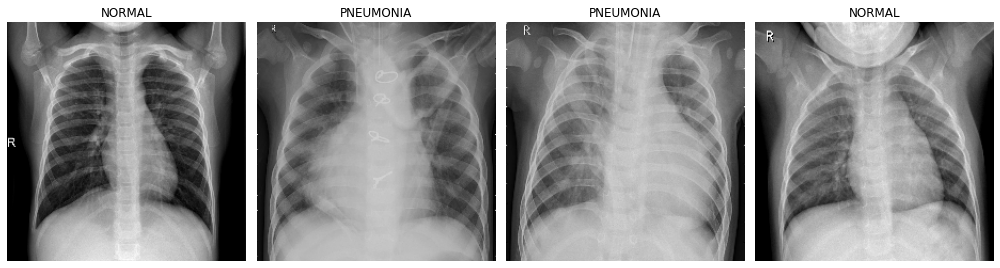

VALIDATION DATASET


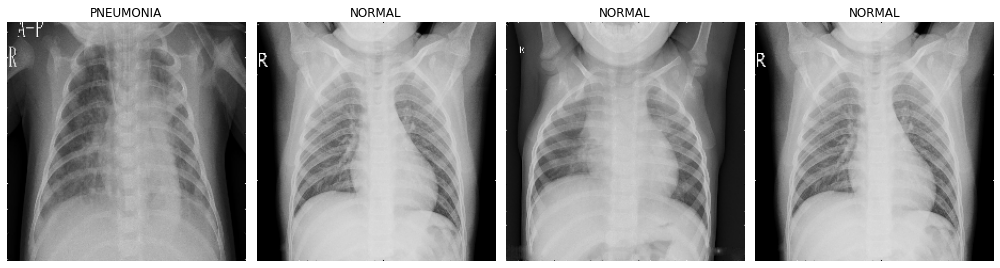

TEST DATASET


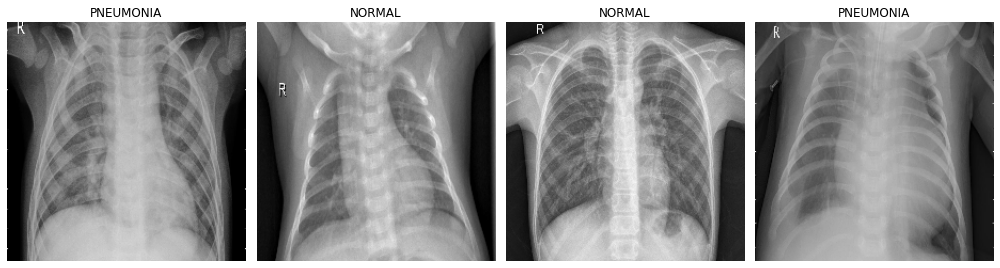

In [8]:
# Visualize some samples from each dataset after mentioned operations
print("TRAIN DATASET")
visualize_data(train_data)
print("VALIDATION DATASET")
visualize_data(val_data)
print("TEST DATASET")
visualize_data(test_data)

In [9]:
# Normalize images to (0.0, 1.0) scale
train_data = image_normalize(train_data)
val_data = image_normalize(val_data)
test_data = image_normalize(test_data)

TRAIN DATASET


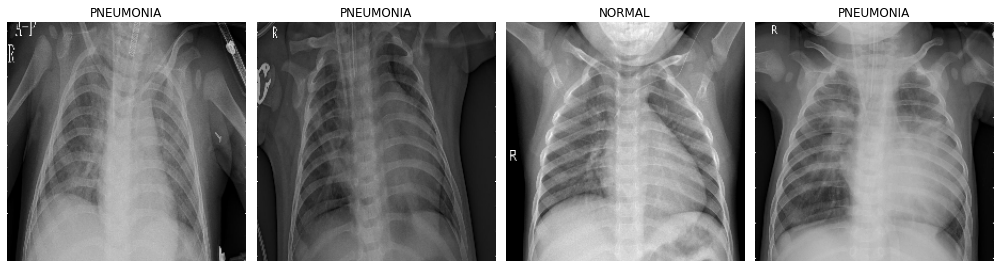

VALIDATION DATASET


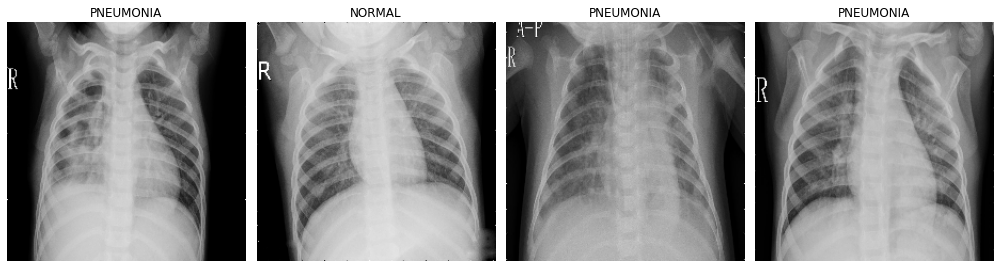

TEST DATASET


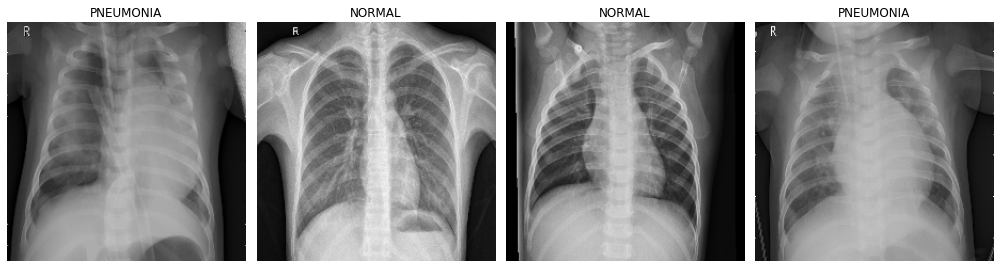

In [10]:
# Visualize some examples now
print("TRAIN DATASET")
visualize_data(train_data)
print("VALIDATION DATASET")
visualize_data(val_data)
print("TEST DATASET")
visualize_data(test_data)

In [11]:
# Make data arrays for the model (the efficent way for training it)
x_train, x_val, x_test = [], [], []
y_train, y_val, y_test = [], [], []

for image, label in train_data:
    x_train.append(image)
    y_train.append(label)

for image, label in val_data:
    x_val.append(image)
    y_val.append(label)

for image, label in test_data:
    x_test.append(image)
    y_test.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train).reshape(-1,1)

x_val = np.array(x_val)
y_val = np.array(y_val).reshape(-1,1)

x_test = np.array(x_test)
y_test = np.array(y_test).reshape(-1,1)

In [12]:
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (5216, 224, 224, 3), y_train shape: (5216, 1)
x_val shape: (16, 224, 224, 3), y_val shape: (16, 1)
x_test shape: (624, 224, 224, 3), y_test shape: (624, 1)


In [13]:
# Save them as pickles for further processing
with open("x_train.pkl", "wb") as f:
    pickle.dump(x_train, f, protocol=4)

with open("y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open("x_val.pkl", "wb") as f:
    pickle.dump(x_val, f)

with open("y_val.pkl", "wb") as f:
    pickle.dump(y_val, f)

with open("x_test.pkl", "wb") as f:
    pickle.dump(x_test, f)

with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

## Model training phase

We follow Vision Transformer network architecture in it's original form. The main paper we base our work on is [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf). We additionally rely on Keras [Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/) for implementation details as well as expand it into our concepts. Other papers, articles and blogs we use to extend the work and experiment with it's efficiency are listed as follows:

* [How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers](https://arxiv.org/pdf/2106.10270.pdf)
* [Transformers for Image Recognition at Scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html?m=1&fbclid=IwAR2YfBl3vKIamsQ5oo_dDIJR1ItHF5GEUr2chDi8pd7EWXxhOw3a_jeqVKA)
* [Training data-efficient image transformers & distillation through attention](https://arxiv.org/pdf/2012.12877.pdf) -> authors propose layer normalization (classic paper proposes group normalization), they dont say about using dropout for DeiT-Ti but Hot to train... suggests 0.1

In [4]:
# Defining global variables
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 64
PATCH_SIZE = 14
NUM_PATCHES = 256
PROJECTION_DIM = 64 # Dimension per head
TRANSFORMER_LAYERS = 6
ATTENTION_HEADS = 3
MLP_HEADS_UNITS = [2048, 1024]
CLASSES = 2
WEIGHT_DECAY = 0.005
LEARNING_RATE = 0.001
NUM_EPOCHS = 200

In [2]:
# LOAD DATA
with open('x_train.pkl', 'rb') as f:
    x_train = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('x_val.pkl', 'rb') as f:
    x_val = pickle.load(f)

with open('y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)

with open('x_test.pkl', 'rb') as f:
    x_test = pickle.load(f)

with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

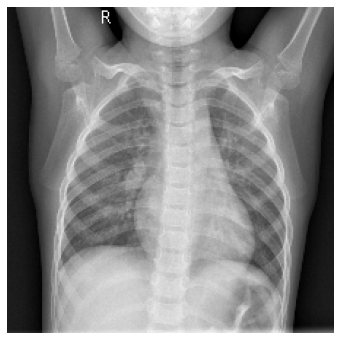

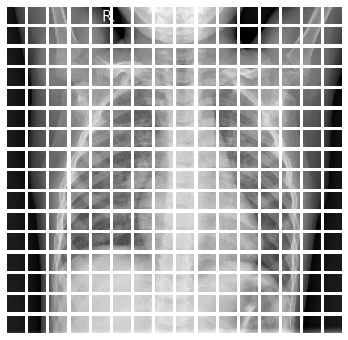

In [7]:
# Patches visualization, in our case the input image has a shape 224 x 224 and we extract it into 256 patches of shape 14 x 14
img = x_train[0]
img = tf.expand_dims(tf.convert_to_tensor(img), 0)

patches = Patches(PATCH_SIZE)(img)

plt.figure(figsize=(6,6))
plt.imshow(img[0])
plt.axis("off")
plt.show()

plt.figure(figsize=(6,6))
for i, patch in enumerate(patches[0]):
    plt.subplot(16, 16, i+1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")
plt.axis("off")
plt.show()

In [4]:
ViT_model = vision_transformer(
    input_shape=INPUT_SHAPE,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    projection_dim=PROJECTION_DIM,
    transformer_layers=TRANSFORMER_LAYERS,
    num_heads=ATTENTION_HEADS,
    mlp_heads_units=MLP_HEADS_UNITS,
    num_classes=CLASSES,
    is_binary=True
)

In [5]:
# Training
SGD_optimizer = optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9)
ViT_model.compile(
    optimizer=SGD_optimizer,
    loss="binary_crossentropy",
    metrics=[metrics.BinaryAccuracy(name="accuracy"), metrics.Recall(name="recall"), metrics.Precision(name="precision")]
)

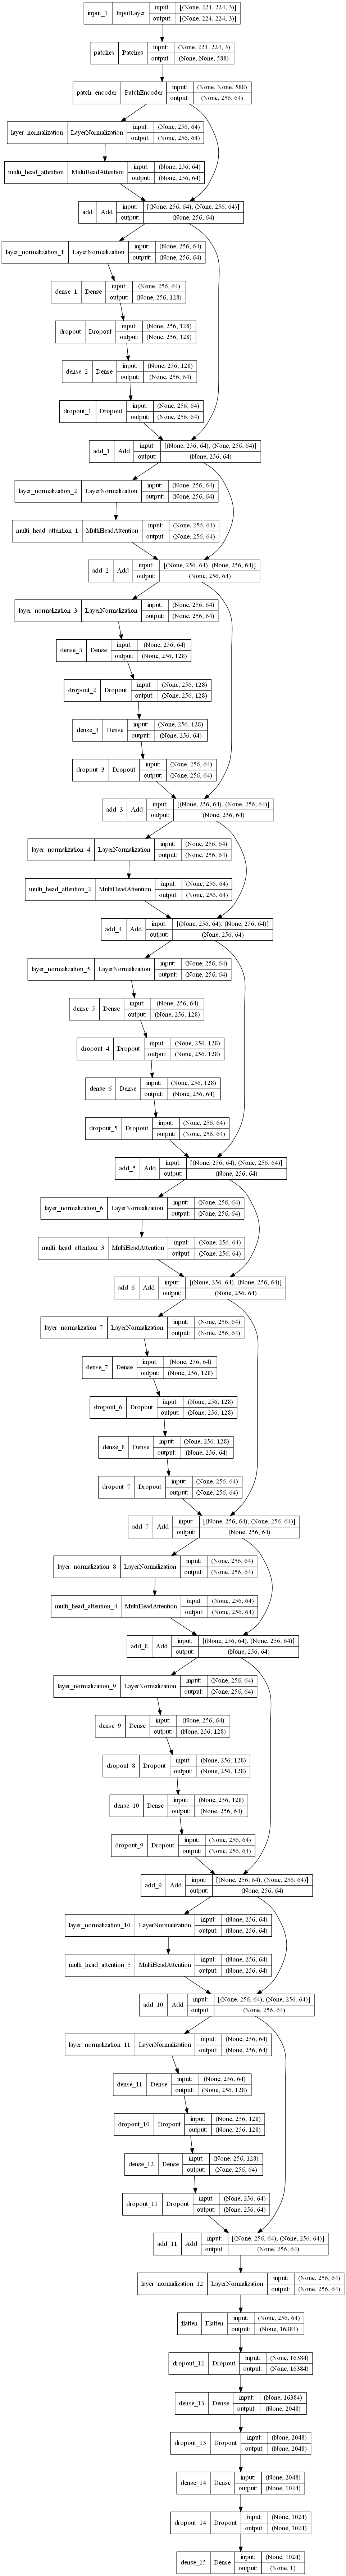

In [19]:
keras.utils.plot_model(ViT_model, show_shapes=True, to_file="ViT_architecture.png")

### IMPORTANT INFO
> Network's training itself was performed in Google Colab and is given in the other notebook - training.ipynb